In [1]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.imputation.mice as mice
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer

%matplotlib inline

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
properties_2016 = pd.read_csv('/Users/daesookim/workspace/zillow/properties_2016.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_df_2016 = pd.read_csv('/Users/daesookim/workspace/zillow/train_2016_v2.csv')
train_2016 = pd.merge(train_df_2016, properties_2016, how ='left', on ='parcelid')

In [4]:
train_2016.loc[train_2016["heatingorsystemtypeid"] == 2.0, "airconditioningtypeid"] = 1.0
train_2016.loc[train_2016["airconditioningtypeid"] == 1.0, "heatingorsystemtypeid"] = 2.0

train_2016.loc[np.isnan(train_2016["airconditioningtypeid"]), "airconditioningtypeid"] = 0.0
train_2016.loc[np.isnan(train_2016["heatingorsystemtypeid"]), "heatingorsystemtypeid"] = 0.0
train_2016[["airconditioningtypeid", "heatingorsystemtypeid"]].isna().sum()

airconditioningtypeid    0
heatingorsystemtypeid    0
dtype: int64

In [5]:
train_2016["fireplaceflag"] = train_2016["fireplaceflag"].astype(float) # True/False -> 1.0/0.0

In [6]:
train_2016.loc[~np.isnan(train_2016["fireplacecnt"]), "fireplacecnt"] = 1.0
train_2016.loc[~np.isnan(train_2016["fireplaceflag"]) , "fireplaceflag"] = 1.0
train_2016.loc[np.isnan(train_2016["fireplacecnt"]), "fireplacecnt"] = 0.0
train_2016.loc[np.isnan(train_2016["fireplaceflag"]), "fireplaceflag"] = 0.0

train_2016[["fireplacecnt", "fireplaceflag"]].isna().sum()

fireplacecnt     0
fireplaceflag    0
dtype: int64

In [7]:
ls = train_2016[np.isnan(train_2016["fullbathcnt"])]["bathroomcnt"]
train_2016.loc[np.isnan(train_2016["fullbathcnt"]), "fullbathcnt"] = ls

train_2016[np.isnan(train_2016["fullbathcnt"])]

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


In [8]:
train_2016["threequarterbathnbr"].value_counts()

1.0    11912
2.0       90
3.0        6
4.0        1
Name: threequarterbathnbr, dtype: int64

In [9]:
train_2016.loc[np.isnan(train_2016["threequarterbathnbr"]), "threequarterbathnbr"] = 1.0
train_2016[np.isnan(train_2016["threequarterbathnbr"])]

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


### 세금과 관련된 컬럼 fill
- structuretaxvaluedollarcnt = taxvaluedollarcnt - landtaxvaluedollarcnt
- taxamount : taxamount와 taxvaluedollarcnt의 비율을 구한다음 평균값을 구해서 taxvaluedollarcnt에 곱해준 값을 채움
- taxdelinquencyflag : Y값은 1로 대체 NaN 값은 0으로 대체

In [10]:
train_2016.loc[np.isnan(train_2016["taxvaluedollarcnt"]), "taxvaluedollarcnt"] = np.mean(train_2016["taxvaluedollarcnt"].notnull())
train_2016.loc[np.isnan(train_2016["landtaxvaluedollarcnt"]), "landtaxvaluedollarcnt"] = np.mean(train_2016["landtaxvaluedollarcnt"].notnull())
train_2016["structuretaxvaluedollarcnt"] = train_2016["taxvaluedollarcnt"] - train_2016["landtaxvaluedollarcnt"]
train_2016.loc[train_2016["taxdelinquencyflag"] == 'Y', "taxdelinquencyflag"] = 1.0
train_2016.loc[train_2016["taxdelinquencyflag"].isnull(), "taxdelinquencyflag"] = 0.0 
for_ratio = train_2016[train_2016["taxamount"].notnull() & train_2016["taxvaluedollarcnt"].notnull()] 
ratio = for_ratio["taxamount"] / for_ratio["taxvaluedollarcnt"]

In [11]:
train_2016.loc[train_2016["taxamount"].isnull(), "taxamount"] = train_2016["taxvaluedollarcnt"] * ratio.mean()

### 층과 관련된 컬럼 Fill
- numberofstories : structuretaxvaluedollarcnt가 0이면 0, 나머지는 1.0으로 채워줌, 최빈값
- 건물세가 없고 층이 Nan값이면 0으로 채움
- 1층 면적이 있고 층이 Nan값이면 1로 채워줌

In [12]:
train_2016.loc[train_2016["numberofstories"].isnull() & train_2016["structuretaxvaluedollarcnt"]==0.0 ,"numberofstories"] = 0.0
train_2016.loc[(train_2016["numberofstories"] == 0.0) & train_2016["finishedfloor1squarefeet"].notnull(), "numberofstories"] = 1.0
train_2016["numberofstories"].fillna(value = 1.0, inplace = True)
#storytypeid: 0으로 채워줌(유무)
train_2016["storytypeid"].fillna(value = 0, inplace = True)
train_2016["basementsqft"].fillna(value = 0, inplace = True)

### 면적과 관련된 컬럼 fill

In [13]:
# 총면적이 1층 면적보다 작은경우 1층 면적을 총면적에 대입
train_2016.loc[train_2016["calculatedfinishedsquarefeet"].notnull() < train_2016["finishedsquarefeet50"].notnull(), "calculatedfinishedsquarefeet"] = train_2016["finishedsquarefeet50"]
# 층수가 없는 경우 총면적의 NaN은 0
train_2016.loc[(train_2016["numberofstories"] == 0.0) & train_2016["calculatedfinishedsquarefeet"].isnull(), "calculatedfinishedsquarefeet"] = 0.0
# 건물이 있지만 총면적이 0인 경우 총면적의 평균을 대입
train_2016.loc[(train_2016["numberofstories"] != 0.0) & train_2016["calculatedfinishedsquarefeet"].isnull(),"calculatedfinishedsquarefeet"] = np.mean(train_2016["calculatedfinishedsquarefeet"].notnull())
# 1층의 면적을 나타내는 finishedfloor1squarefeet, finishedsquarefeet50의 Nan값은 calculatedfinishedsquarefeet의 값으로 대체(대부분 비슷하지만 조금 차이가남)
train_2016.loc[train_2016["finishedfloor1squarefeet"].isnull(), "finishedfloor1squarefeet"] = train_2016["calculatedfinishedsquarefeet"]
train_2016.loc[train_2016["finishedsquarefeet50"].isnull(), "finishedsquarefeet50"] = train_2016["calculatedfinishedsquarefeet"]
train_2016.loc[train_2016["finishedsquarefeet6"].isnull(), "finishedsquarefeet6"] = train_2016["calculatedfinishedsquarefeet"]
# 총면적과 거주 공간외 공간의 면적이 같은 경우 거주 공간의 면적을 0으로 넣어줌
train_2016.loc[train_2016["calculatedfinishedsquarefeet"].notnull() == train_2016["finishedsquarefeet13"].notnull(), "finishedsquarefeet12"] = 0.0
# finishedsquarefeet12의 NaN값은 calculatedfinishedsquarefeet와 일치 
train_2016.loc[train_2016["finishedsquarefeet12"].isnull(), "finishedsquarefeet12"] = train_2016["calculatedfinishedsquarefeet"]
train_2016["finishedsquarefeet13"].fillna(value = 0.0, inplace=True)
# finishedsquarefeet15 : calculatedfinishedsquarefeet의 값으로 채워줌
train_2016.loc[train_2016["finishedsquarefeet15"].isnull(), "finishedsquarefeet15"] = train_2016["calculatedfinishedsquarefeet"]
# lotsizesquarefeet의 값이  finishedsquarefeet50(1층면적) 보다 작은 경우 1층면적으로 대체
train_2016.loc[train_2016["finishedsquarefeet50"] > train_2016["lotsizesquarefeet"], "lotsizesquarefeet"] = train_2016["finishedsquarefeet50"]
# calculatedfinishedsquarefeet(총면적)이 있는데 lotsizesquarefeet이 NaN인 경우 1층의 값으로 대입
train_2016.loc[train_2016["lotsizesquarefeet"].isnull() & train_2016["calculatedfinishedsquarefeet"].notnull(), "lotsizesquarefeet"] = train_2016["finishedsquarefeet50"]

train_2016.loc[train_2016["yearbuilt"].isnull() & train_2016["buildingqualitytypeid"] == 7.0, "yearbuilt"] = 1950
train_2016.loc[train_2016["yearbuilt"].isnull() & train_2016["buildingqualitytypeid"] == 4.0, "yearbuilt"] = 1979
train_2016["yearbuilt"].fillna(value = 1955, inplace = True)

train_2016.loc[train_2016["unitcnt"].isnull() & (train_2016["calculatedfinishedsquarefeet"] == 0), "unitcnt"] = 0
train_2016["unitcnt"].fillna(value = 1, inplace = True)

### 건설 시기, 건물 구조물 등 컬럼 fill

In [14]:
train_2016["decktypeid"].fillna(value = 0.0, inplace = True)
train_2016.loc[train_2016["decktypeid"] == 66.0 , "decktypeid"] = 1
train_2016.loc[train_2016["buildingqualitytypeid"].isnull() & (train_2016["structuretaxvaluedollarcnt"] == 0), "buildingqualitytypeid"]=0
train_2016.loc[train_2016["buildingqualitytypeid"].isnull(), "buildingqualitytypeid"] = train_2016["buildingqualitytypeid"].mode()[0]
train_2016.loc[train_2016["buildingclasstypeid"].notnull(), "buildingclasstypeid"] = 1
train_2016.loc[train_2016["buildingclasstypeid"].isnull(), "buildingclasstypeid"] = 0
train_2016["architecturalstyletypeid"].fillna(value=7, inplace=True)
train_2016['typeconstructiontypeid'].fillna(value=6, inplace=True)

In [15]:
train_2016.loc[train_2016.yardbuildingsqft17.isnull(), 'yardbuildingsqft17'] = 0.0
train_2016[['garagecarcnt', 'garagetotalsqft']][(train_2016.garagetotalsqft != 0) & (train_2016.garagecarcnt == 0)]
train_2016.loc[57609, 'garagecarcnt'] = 1.0
prop_garages =  ['garagecarcnt', 'garagetotalsqft']
mean_garagesqft = train_2016[prop_garages].groupby(['garagecarcnt']).agg('mean')

In [16]:
def garagesqft_fillna(garagecarcnt):
    x = round(mean_garagesqft.loc[garagecarcnt][0], 0)
    print(x)
    train_2016.loc[(train_2016.garagecarcnt == garagecarcnt) & (train_2016.garagetotalsqft == 0),'garagetotalsqft'] = x

In [17]:
for i in mean_garagesqft.index[1:] :
    garagesqft_fillna(i)

125.0
391.0
759.0
969.0
1304.0
1646.0
1982.0
2313.0
2704.0
3077.0
3355.0
4048.0
4384.0
7339.0


In [18]:
train_2016["garagecarcnt"].fillna(value=0, inplace=True)
train_2016["garagetotalsqft"].fillna(value=0, inplace=True)
train_2016.poolcnt.fillna(value=0.0, inplace=True)
train_2016['pooltypeid2'].fillna(value=0, inplace=True)
train_2016['pooltypeid7'].fillna(value=0, inplace=True)
train_2016['pooltypeid10'].fillna(value=0, inplace=True)

In [19]:
model_poolsizesum = sm.OLS.from_formula("poolsizesum~I(finishedsquarefeet50*0.01)+I(garagetotalsqft*0.01)+C(poolcnt)+0", data = train_2016)
poolsizesum_result = model_poolsizesum.fit()
predicted_poolsizesum = poolsizesum_result.predict(train_2016[['poolcnt','finishedsquarefeet50', 'garagetotalsqft']].dropna())

In [20]:
for i in predicted_poolsizesum.index :
    if train_2016.loc[i, 'poolcnt'] > 0:
        train_2016.loc[i, 'poolsizesum'] = round(predicted_poolsizesum.loc(0)[i], 0)
    else:
        pass
train_2016.loc[train_2016["poolsizesum"].isnull() & (train_2016["poolcnt"]==0), "poolsizesum"] = 0
for_mean = train_2016[train_2016["poolcnt"]==1]["poolsizesum"]
train_2016.loc[(train_2016["poolcnt"] == 1) & train_2016["poolsizesum"].isnull(), "poolsizesum"] = for_mean.dropna().mean()
train_2016["yardbuildingsqft26"].fillna(value=1, inplace=True)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,7.0,0.0,2.0,3.0,0.0,4.0,...,1.0,0.0,122754.0,360170.0,2015.0,237416.0,6735.88,0,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,0.0,7.0,0.0,3.5,4.0,0.0,7.0,...,1.0,0.0,346458.0,585529.0,2015.0,239071.0,10153.02,0,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,7.0,0.0,3.0,2.0,0.0,4.0,...,1.0,0.0,61994.0,119906.0,2015.0,57912.0,11484.48,0,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,7.0,0.0,2.0,2.0,0.0,4.0,...,1.0,0.0,171518.0,244880.0,2015.0,73362.0,3048.74,0,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,0.0,7.0,0.0,2.5,4.0,0.0,7.0,...,0.0,0.0,169574.0,434551.0,2015.0,264977.0,5488.96,0,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,1.0,7.0,0.0,4.0,4.0,0.0,1.0,...,1.0,0.0,880650.0,2447951.0,2015.0,1567301.0,27126.57,0,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,0.0,7.0,0.0,1.0,2.0,0.0,7.0,...,1.0,0.0,64549.0,111521.0,2015.0,46972.0,2304.97,0,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,0.0,7.0,0.0,2.5,3.0,0.0,7.0,...,1.0,0.0,107000.0,306000.0,2015.0,199000.0,3745.50,0,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,0.0,7.0,0.0,1.0,2.0,0.0,7.0,...,1.0,0.0,66834.0,210064.0,2015.0,143230.0,2172.88,0,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,0.0,7.0,0.0,2.0,2.0,0.0,7.0,...,0.0,0.0,109977.0,190960.0,2015.0,80983.0,1940.26,0,NaN,6.059063e+13


In [21]:
model = sm.OLS.from_formula("logerror ~  scale(basementsqft)+ scale(finishedsquarefeet13) + scale(lotsizesquarefeet)\
                            +scale(unitcnt)+ scale(threequarterbathnbr) + scale(buildingqualitytypeid)+ scale(bedroomcnt)\
                            + scale(threequarterbathnbr)+ scale(fips)+ scale(roomcnt)+ scale(taxamount)+scale(garagetotalsqft)\
                            +scale(bathroomcnt) + scale(poolsizesum)", train_2016)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     12.94
Date:                Fri, 06 Jul 2018   Prob (F-statistic):           4.64e-29
Time:                        13:24:24   Log-Likelihood:                 36819.
No. Observations:               90275   AIC:                        -7.361e+04
Df Residuals:                   90261   BIC:                        -7.348e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

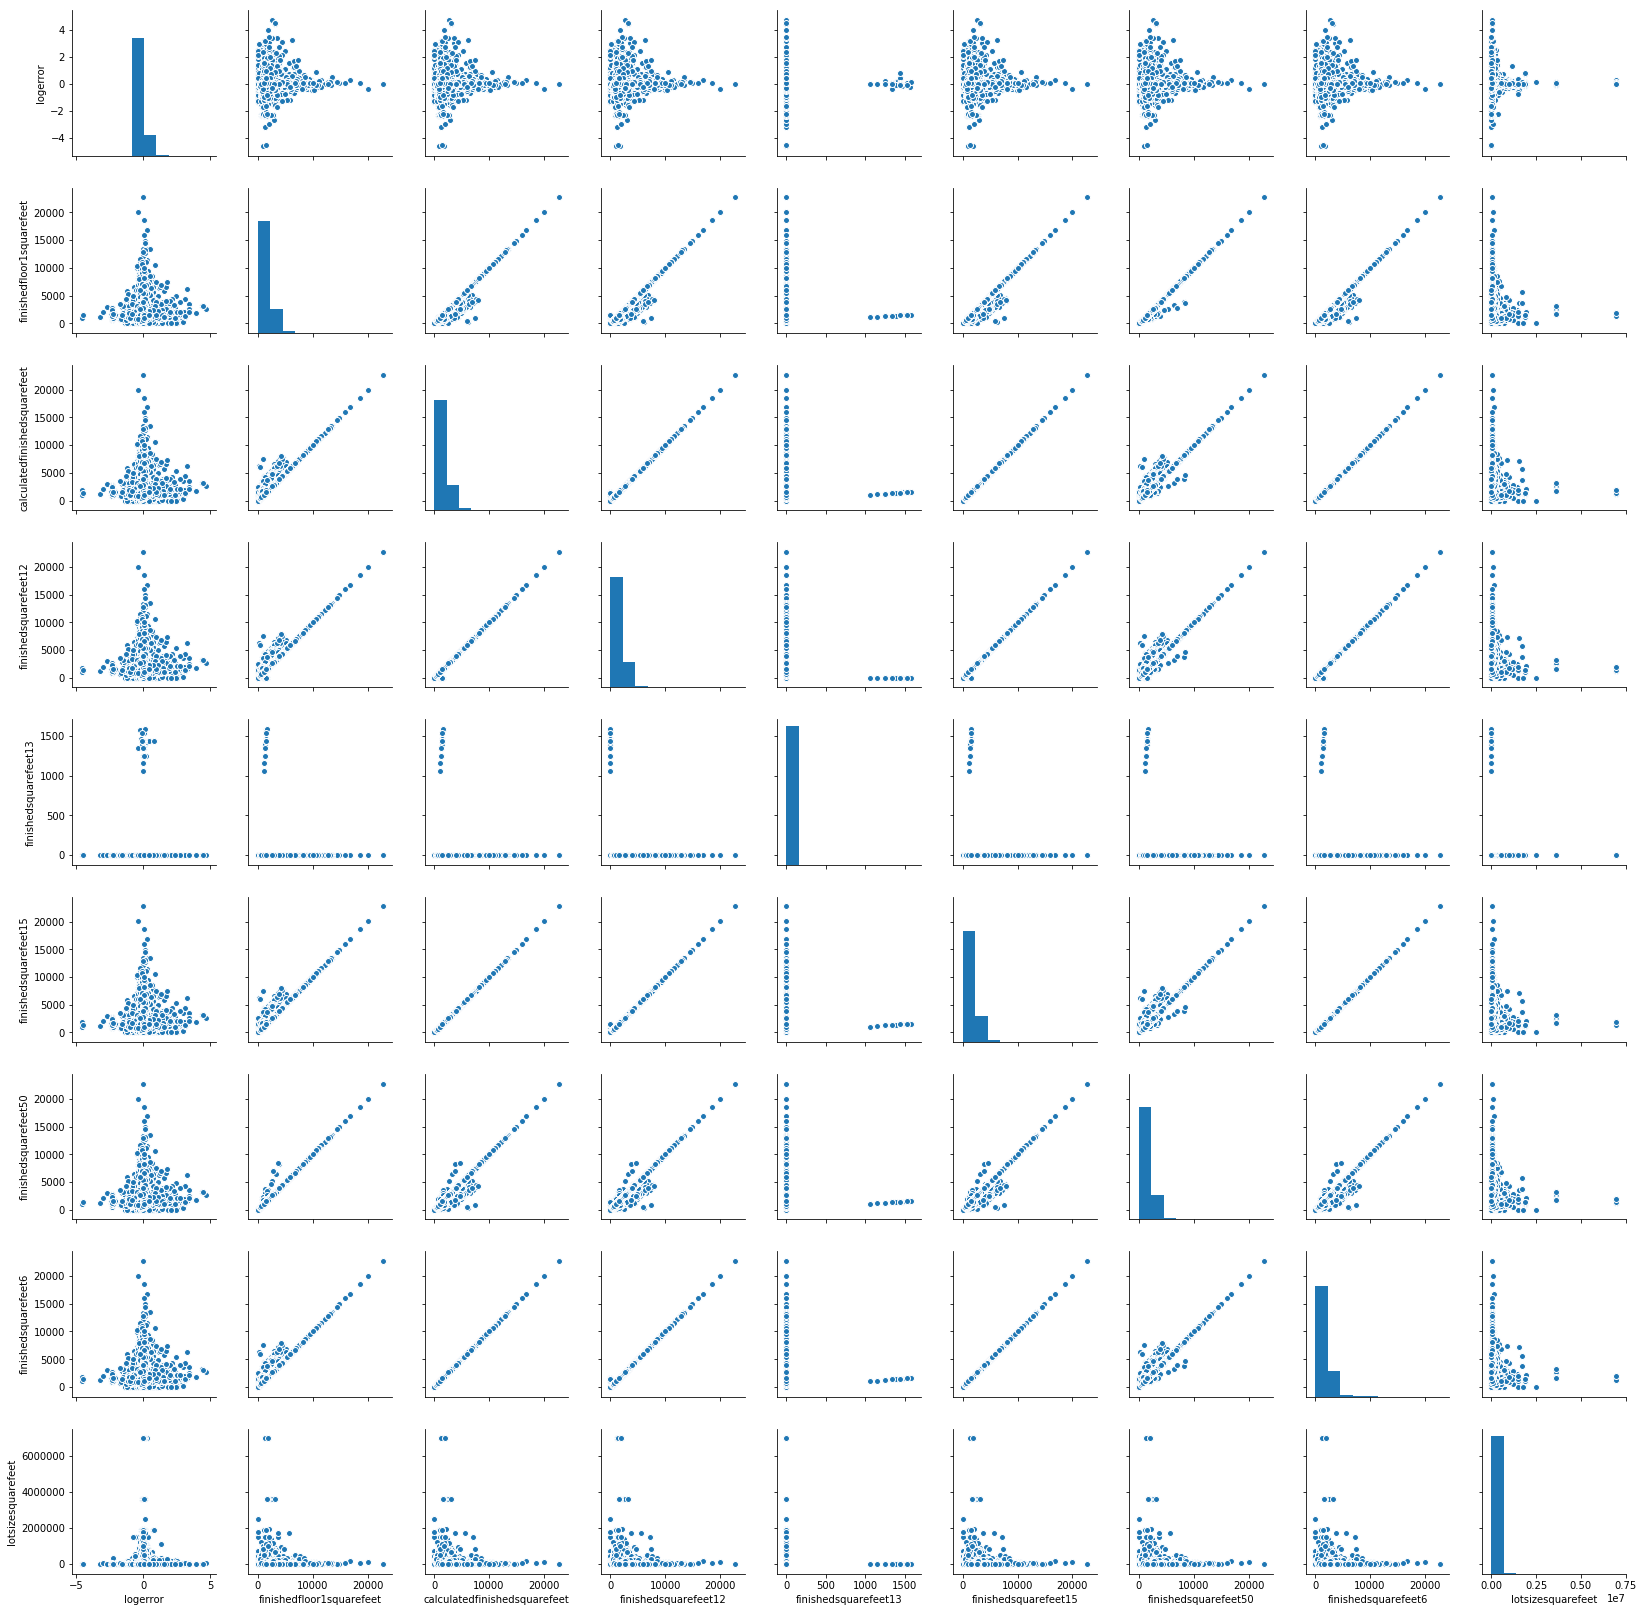

In [22]:
cols = ["logerror", "finishedfloor1squarefeet",  "calculatedfinishedsquarefeet", "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "finishedsquarefeet6", "lotsizesquarefeet"]
sns.pairplot(train_2016[cols])
plt.show()

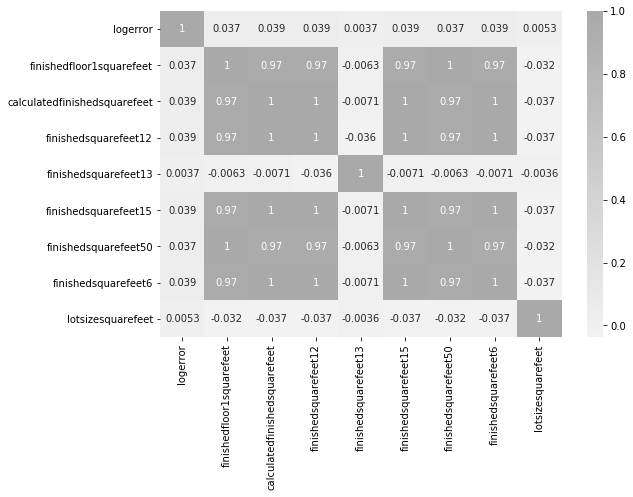

In [23]:
#dfX = dmatrix(formula, dfX0, return_type="dataframe")
plt.figure(figsize=(9,6))
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(train_2016[cols].corr(), annot=True, cmap=cmap)
plt.show()

In [24]:
train_2016.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
count,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,89093.000000,...,90275.000000,90275.000000,9.027500e+04,9.027500e+04,90275.0,9.027500e+04,90275.000000,90275.000000,1783.000000,8.967000e+04
mean,1.298466e+07,0.011457,0.720930,7.000665,0.339895,2.279474,3.031869,0.000177,6.063129,2.309216,...,0.844032,0.002459,1.793353e+05,4.576676e+05,2015.0,2.783322e+05,5983.741494,0.019751,13.402692,6.049151e+13
std,2.504510e+06,0.161079,1.869014,0.146291,18.205899,1.004271,1.156436,0.013312,1.703630,0.976172,...,0.362827,0.049529,2.090147e+05,5.548834e+05,0.0,4.004943e+05,6838.717300,0.139143,2.715966,2.046605e+11
min,1.071174e+07,-4.605000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000e+00,9.999889e-01,2015.0,9.999889e-01,49.080000,0.000000,6.000000,6.037101e+13
25%,1.155950e+07,-0.025300,0.000000,7.000000,0.000000,2.000000,2.000000,0.000000,4.000000,2.000000,...,1.000000,0.000000,8.064100e+04,1.990125e+05,2015.0,8.222750e+04,2872.680000,0.000000,13.000000,6.037320e+13
50%,1.254734e+07,0.006000,0.000000,7.000000,0.000000,2.000000,3.000000,0.000000,7.000000,2.000000,...,1.000000,0.000000,1.315070e+05,3.428720e+05,2015.0,1.929600e+05,4542.440000,0.000000,14.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,0.000000,3.000000,4.000000,0.000000,7.000000,3.000000,...,1.000000,0.000000,2.100425e+05,5.405890e+05,2015.0,3.454150e+05,6900.600000,0.000000,15.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,1555.000000,20.000000,16.000000,1.000000,12.000000,20.000000,...,1.000000,1.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,1.000000,99.000000,6.111009e+13


In [25]:
ratio_fill_data_2016 = train_2016.drop(['parcelid'], axis=1).count()/len(train_2016)
sorted_ratio_2016 = ratio_fill_data_2016.sort_values()

sorted_ratio_2016

taxdelinquencyyear              0.019751
hashottuborspa                  0.026198
regionidneighborhood            0.398914
propertyzoningdesc              0.645948
regionidcity                    0.980028
calculatedbathnbr               0.986907
censustractandblock             0.993298
regionidzip                     0.999612
propertycountylandusecode       0.999989
pooltypeid7                     1.000000
propertylandusetypeid           1.000000
taxdelinquencyflag              1.000000
taxamount                       1.000000
rawcensustractandblock          1.000000
landtaxvaluedollarcnt           1.000000
regionidcounty                  1.000000
assessmentyear                  1.000000
structuretaxvaluedollarcnt      1.000000
fireplaceflag                   1.000000
storytypeid                     1.000000
threequarterbathnbr             1.000000
pooltypeid2                     1.000000
unitcnt                         1.000000
yardbuildingsqft17              1.000000
yardbuildingsqft

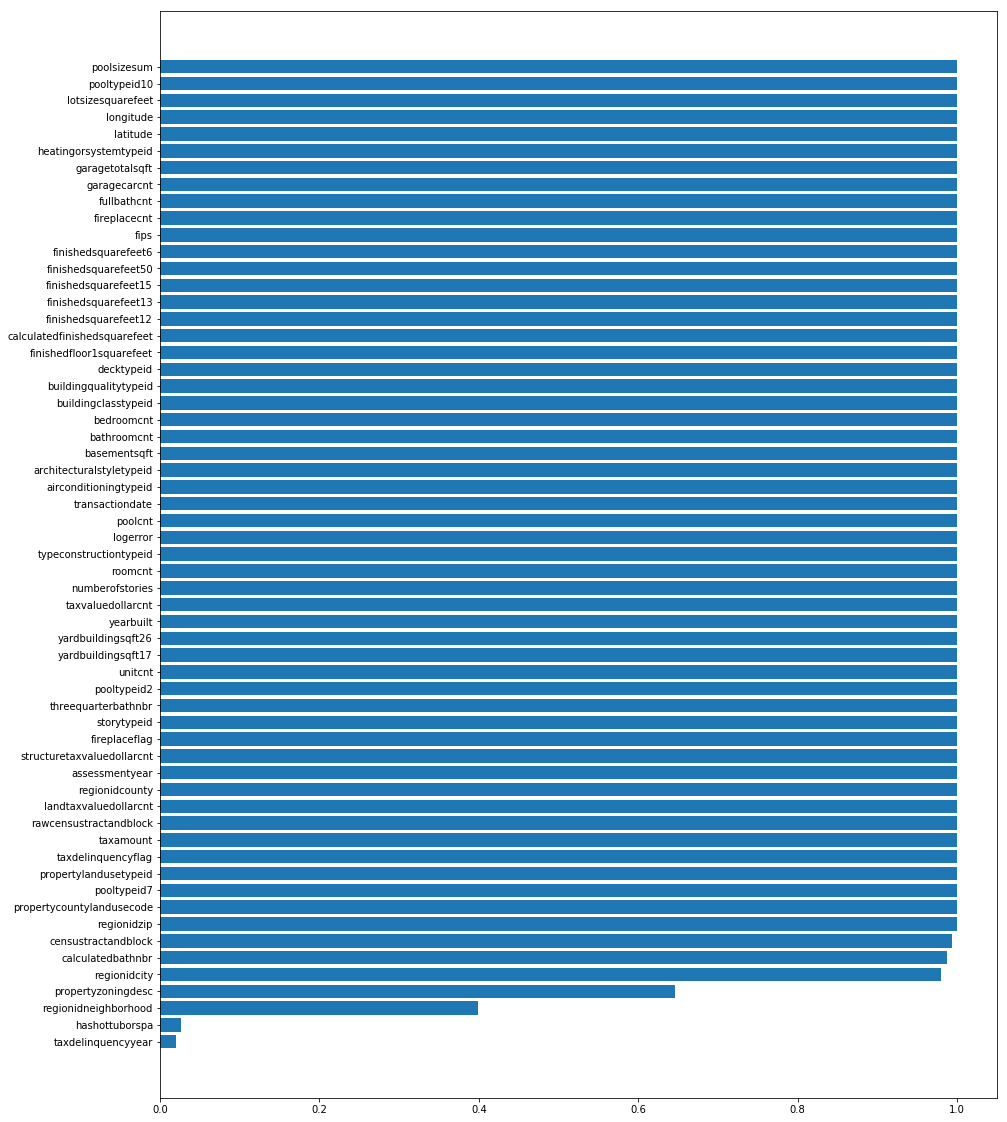

In [26]:
plt.figure(figsize=(15, 20))
plt.barh(sorted_ratio_2016.index, sorted_ratio_2016.values)
plt.show()

In [27]:
from patsy import dmatrix
from statsmodels.stats.outliers_influence import variance_inflation_factor


formula  = "scale(poolsizesum) + scale(lotsizesquarefeet) + scale(garagetotalsqft) \
+scale(garagecarcnt) + scale(fullbathcnt) + scale(fips)+ scale(finishedsquarefeet6) \
+scale(finishedsquarefeet13)+scale(calculatedfinishedsquarefeet)+scale(finishedfloor1squarefeet)\
+scale(buildingqualitytypeid)+scale(bedroomcnt)+scale(bathroomcnt)\
+scale(basementsqft)+scale(poolcnt)+scale(roomcnt)+scale(numberofstories)+scale(taxvaluedollarcnt)\
+scale(unitcnt)+scale(threequarterbathnbr)+scale(structuretaxvaluedollarcnt)+scale(landtaxvaluedollarcnt)+scale(taxamount)"
dfX = dmatrix(formula, train_2016, return_type="dataframe")
            

In [28]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

/usr/local/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.000000,Intercept
1,1.005811,scale(basementsqft)
2,1.023234,scale(finishedsquarefeet13)
3,1.054002,scale(lotsizesquarefeet)
4,1.078562,scale(unitcnt)
5,1.098464,scale(threequarterbathnbr)
6,1.298899,scale(buildingqualitytypeid)
7,2.343883,scale(bedroomcnt)
8,4.945878,scale(numberofstories)
9,5.142067,scale(fips)
